# Capstone project



## Algorithm for flower Identification App 



### Introduction

The Internet has made it easier for people to gather information on websites, and more recently through smartphones applications. 2.32 billions people possess smartphones today and this number is expected to consistenly increase throughout years. A smartphone application saves people from time consuming and slow process of seeking information from books and encyclopedias like before.

An App to identify flower can used by a flower shop to attract consumers to theirs shops, by campers/scouters, students... who are curious of nature. 


In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile  app.  At the end of this project, our code will accept any user-supplied image as input. With an image of a flower, the app will do its best to recognise it and gives its name. 


### The Road Ahead

We break the notebook into separate parts.This part concerns the Comvolutional Neural Network(CNN)model.  
* [PART 1]: Oxford 102 flower Dataset
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Visualise some images
* [Step 2](#step2): Preprocess the data


* [PART 2]: Creating a CNN to classify flowers
* [Step 0](#step0): Preprocess the data
* [step 1](#step1): Implement the Model Architecture
* [step 2](#step2): Train the Model 
* [step 3](#step3): Test the Model
* [step 4](#step4): Evaluate the Model 


<a id='step4'></a>


## PART 1: Oxford 102 Flower Dataset

## Step 0: Import Datasets

In the code cell below, we import a dataset of flower images: Oxford 102 Flower Dataset. It contains images of flowers belonging to 102 different categories. Each class/category consists of between 40 and 258 images and it has a total of 8189 images.

The datasplits used are specified in setid.mat: there is a training file (trnid), a validation file (valid)
and a testfile (tstid) and the image labels are specified in imagelabels.mat.

In [1]:
import cv2
import math
import keras
import h5py
import string
import numpy as np
import os, shutil
import time, datetime
import random

from scipy.io import loadmat
from sklearn.datasets import load_files       
from glob import glob
from keras.utils import np_utils
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Activation
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import preprocess_input
from keras.utils.np_utils import to_categorical  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout, Flatten, Dense, Input, Activation, Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Conv2D

from sklearn.datasets import load_files       
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.classification import accuracy_score, log_loss


# important for testing
img_width = 224 #168, 112, 56, 224
img_height = 224 #168, 112, 56, 224
img_size = (img_width, img_height)

def size_str():
    return "x".join([str(i) for i in img_size])

def tijdregel():
    tm = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    strp = "="* int((80-2-len(tm))/2)
    print(strp,tm,strp)

def load_dataset(path):
    data = load_files(path)
    flower_files = np.array(data['flowers'])
    flower_targets = np_utils.tocategorical(np.array(data['target']), nr_classes)
    return flower_files, flower_targets

def flower_nr_to_file(flower_nr, flower_path=""):
    """flower filenames for numbers under 10000"""
    nr = str(flower_nr)
    zeroes = (5 - len(nr)) * "0"
    filename =  "image_"+zeroes+nr+".jpg"
    if flower_path is not "":
        filename = os.path.join(flower_path, filename)
    return filename
   
print("We are using Keras version", keras.__version__)
    
tijdregel()
flower_image_path = os.path.join(os.getcwd(), "flowers")

setid_file = 'setid.mat'
setid = loadmat(setid_file)

# -1 to get 0-based files
training_indexes = setid['trnid'].flatten()-1
training_files = [flower_nr_to_file(i, flower_image_path) for i in training_indexes]
    

validation_indexes = setid['valid'].flatten()-1
validation_files = [flower_nr_to_file(i, flower_image_path) for i in validation_indexes]
validation_targets = [flower_nr_to_file(i, flower_image_path) for i in validation_indexes]
# to prepare bottleneck features
for file in validation_files:
    # alle training files naar een aparte map kopieren
    # map training aanmaken (moet niet elke keer)
    destination = file.replace("flowers","validation/flowers")
    # print(file, destination)
    if not os.path.exists(destination):
        shutil.copy(file, destination)


test_indexes = setid['tstid'].flatten()-1
test_files = [flower_nr_to_file(i, flower_image_path) for i in test_indexes]
test_targets = [flower_nr_to_file(i, flower_image_path) for i in test_indexes]


# list of flowers names 
imagelabels_file = 'imagelabels.mat'
imagelabels_data = loadmat(imagelabels_file)

imagelabels = imagelabels_data['labels'].flatten()-1
train_label = imagelabels[training_indexes]
validation_label = imagelabels[validation_indexes]
test_label = imagelabels[test_indexes]


# print statistics
nr_training_files =  len(training_files)
nr_validation_files = len(validation_files)
nr_test_files = len(test_files)
nr_files = len(imagelabels)
nr_classes = len(set(validation_label))
print("We use the following image size:", "x".join([str(i) for i in img_size]) )
print('There are %d flower training images.' % nr_training_files)
print('There are %d flower validation images.' % nr_validation_files)
print('There are %d flower test images.\n' % nr_test_files)
print('There are %d total flower images.' % nr_files)
print('There are %d flower classes.' % (nr_classes))
#print('There are %s total images.\n' % len(np.hstack([training_files, validation_files, test_files])))

Using TensorFlow backend.


We are using Keras version 2.1.2
=============================== 2018-01-26 16:41 ===============================
We use the following image size: 224x224
There are 1020 flower training images.
There are 1020 flower validation images.
There are 6149 flower test images.

There are 8189 total flower images.
There are 102 flower classes.


## Step 1: Visualise the first 12 training images

It is very important to visualise the kind of images we are dealing with in terms of size, shape, pixel, background and color, in order to understand them.  

=============================== 2018-01-26 16:41 ===============================


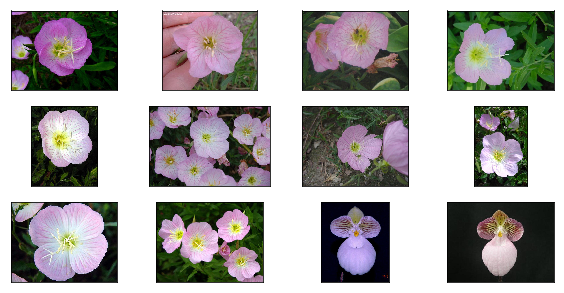

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

tijdregel()

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10,5))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(training_files[i], ax)


## Step 2: Pre-process the Data

Keras CNNs(when using TensorFlow as backend) require a 4D array (which we'll also refer to as a 4D tensor) as input. The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 224×224pixels.


In [3]:
#Pre-process the Data

from keras.preprocessing import image                  
from tqdm import tqdm
from IPython.display import display
from PIL import Image
                
Image.LOAD_TRUNCATED_IMAGES = True   


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---
## PART 2 : Create a CNN to classify flowers



## Step 0: Preprocess the data

In this step, we will create a CNN that classifies flower. Now we can process each image to produce its feature representation; the preprocessing includes converting the images format and resizing those images to be used for keras.

In [4]:
tijdregel()
time.sleep(.3) # to avoid progress bar racing tijdregel output

train_tensors = paths_to_tensor(training_files).astype('float32')/255
valid_tensors = paths_to_tensor(validation_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

for i in [train_tensors,valid_tensors,test_tensors]:
    print(i.shape)

=============================== 2018-01-26 16:41 ===============================


100%|██████████| 6149/6149 [00:34<00:00, 178.67it/s]


(1020, 224, 224, 3)
(1020, 224, 224, 3)
(6149, 224, 224, 3)


## Step 1: Implement the Model Architecture 

Once we've preprocessed data, we can then train a simple classifier. Just as with neural network, a Convolutional Neural Network(CNN) is created by first creating a sequential model;

Convolutional Networks are commonly made up of only three layer types: CONV, POOL (in this case Max pool) and FC ( fully-connected). I also explicitly write the RELU activation function as a layer;

I begin with convolutional layer which detects regional patterns in an image;

MaxPooling appears after convolutional layers to reduce the dimensionality of our arrays;
Our dataset is not complicated (hasn’t got many different object category),  it therefore does not need a very large number of filters. A filter size of 16 allows us to express more powerful features of the input, and with fewer parameters;

Because I want to pad the input such a way that output x,y dimensions are same as that of input( not loosing some nodes in the convolutional layer), I set padding = ‘same’;

I add a ReLu activation function to all of the hidden layers (except the last one) because it helps the function to attain a much better accuracy;

The role of the pooling layers is to reduce dimensionality (can lead to overfitting) that might be caused by the number of filters. Max pooling layer is specifically used to decrease the spatial dimensions;

I used 102 as number of nodes in the final layer because it is also the number of classes in the dataset;
We add two dense layers (one hidden) to generate the flower type predictions. The dense layers allows for non-linear relationships of the features to be used to classifyflowers;

I am using the dropout technique, which randomly ignores a subset of input weights to prevent over-fitting to the training dataset;

Finally, I add a softmax activation function to the final fully connected layer to ensure that the network outputs an estimate for the probability that each potential digit is depicted in the image.

In [5]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu')) 
model.add(Dropout(0.4))
model.add(Dense(nr_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

In [6]:
# compile the model 
tijdregel()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'rmsprop', metrics=["accuracy"])


=============================== 2018-01-26 16:42 ===============================


## Step 2: Train the Model

We train our model in the code cell below and the model checkpointing to save the model that attains the best validation loss.

In [7]:
from keras.callbacks import ModelCheckpoint  

tijdregel()

# checkpoint
batch_size = 16
# this model is overfitting quite a lot, no need to go further than 10-15 epochs.
epochs = 30

saved_model_file=os.path.join(os.getcwd(),"saved_models","weights.best.hdf5")

checkpointer = ModelCheckpoint(saved_model_file, verbose=1, save_best_only=True)
callbacks_list = [checkpointer]


my_history = model.fit(train_tensors, train_label,
          validation_data=(valid_tensors, validation_label),
          epochs=epochs, batch_size=batch_size,
          callbacks=[checkpointer], verbose=1)



=============================== 2018-01-26 16:42 ===============================
Train on 1020 samples, validate on 1020 samples
Epoch 1/30
1020/1020 [==============================] - 70s 69ms/step - loss: 4.8410 - acc: 0.0186 - val_loss: 4.3917 - val_acc: 0.0549
Epoch 2/30
1020/1020 [==============================] - 80s 78ms/step - loss: 4.0477 - acc: 0.0873 - val_loss: 3.8028 - val_acc: 0.1255
Epoch 3/30
1020/1020 [==============================] - 80s 78ms/step - loss: 3.1533 - acc: 0.2353 - val_loss: 3.4945 - val_acc: 0.1716
Epoch 4/30
1020/1020 [==============================] - 75s 73ms/step - loss: 1.8958 - acc: 0.5480 - val_loss: 3.4933 - val_acc: 0.2118
Epoch 5/30
1020/1020 [==============================] - 68s 66ms/step - loss: 0.8090 - acc: 0.7980 - val_loss: 3.8828 - val_acc: 0.1745
Epoch 6/30
1020/1020 [==============================] - 68s 66ms/step - loss: 0.3350 - acc: 0.9245 - val_loss: 3.9237 - val_acc: 0.2196
Epoch 7/30
1020/1020 [==============================] -

### Load the Model with the Best Validation Loss

In [8]:
tijdregel()

model.load_weights(os.path.join(os.getcwd(),"saved_models","weights.best.hdf5"))

=============================== 2018-01-26 17:17 ===============================


=============================== 2018-01-26 17:17 ===============================


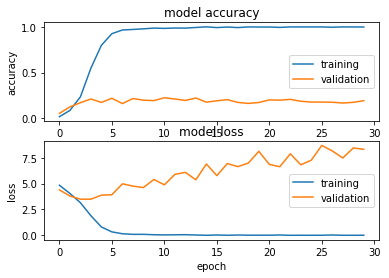

In [9]:
tijdregel()
def plot_learning_history(history):
    assert type(history) is keras.callbacks.History
    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='center right')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='center right')
    plt.show()


# show the learning graph
plot_learning_history(my_history)

## Step 3: Test the Model

We try out our model on the test dataset of flower images.

In [10]:
tijdregel()
model.load_weights(saved_model_file)
flower_pred_proba = model.predict_proba(test_tensors, verbose=1)
flower_predictions = list(np.argmax(flower_pred_proba, axis=1)) # re-using saves time!
print("Done!")

=============================== 2018-01-26 17:17 ===============================
6149/6149 [==============================] - 73s 12ms/step
Done!


## Step 4:  Evaluate the Model 

In [11]:
tijdregel()

# report test accuracy
test_accuracy = 100*np.sum(np.array(flower_predictions)==test_label)/len(flower_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# report Log Loss
from sklearn.metrics import log_loss
loss = log_loss(test_label, flower_pred_proba, eps=.1)
print ('Log loss: %.4f' % loss)

# report f1 score
from sklearn.metrics import f1_score
F1_score = f1_score(test_label,flower_predictions,labels=list(set(validation_label)),average='macro')
print('F1 score: %.4f' % F1_score)

=============================== 2018-01-26 17:19 ===============================
Test accuracy: 17.7590%
Log loss: 4.4012
F1 score: 0.1551


** References **

http://www.robots.ox.ac.uk/~vgg/data/flowers/102/

(https://www.statista.com/statistics/330695/number-of-smartphone-users-worldwide/)

https://github.com/fchollet/keras/tree/master/keras/applications)

https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

https://machinelearningmastery.com/check-point-deep-learning-models-keras/


Udacity's course material(Deep Learning):

-cifar10_augmentation.ipynb

-cifar10_cnn.ipynb

-conv_visualization.ipynb

-My Dog breed App project

https://www.quora.com/Do-convolutional-neural-networks-work-better-on-image-classification-problems-than-recurrent-neural-networks

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/preprocessing/image/    